In [36]:
# Uvoz potrebnih biblioteka
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor                         # regresijski problem
from sklearn.tree import DecisionTreeClassifier                         # klasifikacijski problem
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [37]:
data=pd.read_csv('eshop.csv', delimiter=';')
data.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [38]:
data_tree = data.copy()
data_tree = data_tree.drop_duplicates()

# The line below was problematic as it reassigned data_tree from df,
# potentially losing 'price' and 'order' columns if df didn't have them.
# data_tree = df.reset_index(drop=True)

# Corrected: Drop 'price' and 'order' directly from the `data_tree`
# that was copied from `data`, and specify axis=1 for columns.
data_tree = data_tree.drop(['price','order'], axis=1)

# If an index reset is needed for `data_tree`, apply it here:
data_tree = data_tree.reset_index(drop=True)

drop_columns = ['page 2 (clothing model)', 'country', 'session ID', 'colour', 'location', 'month']
data_tree.drop(drop_columns, axis=1, inplace=True)
data_tree.head()

#enkodiranje
data_tree_encoded = pd.get_dummies(
    data_tree,
    columns=[
        'page 1 (main category)',
        'price 2',
        'model photography'

    ],
    drop_first=True
)
data_tree_encoded.head()

,year,day,page,page 1 (main category)_2,page 1 (main category)_3,page 1 (main category)_4,price 2_2,model photography_2
0,2008,1,1,False,False,False,True,False
1,2008,1,1,False,False,False,True,False
2,2008,1,1,True,False,False,False,False
3,2008,1,1,True,False,False,True,True
4,2008,1,1,True,False,False,False,True


In [39]:
median = np.median(data_tree['price 2'])
print(median)
data_tree['PriceHigh'] = (data_tree['price 2'] > data_tree['price 2'].median()).astype(int)

1.0


In [40]:
X_tree = data_tree.drop(['PriceHigh','price 2'], axis=1)   # axis=1 označava da ispuštamo stupac (axis=0 bi ispustio redak).
y_tree = data_tree['PriceHigh']

In [41]:
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42)


In [42]:
model_stabla = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)  # Ako bi bio klasifikacijski model, ciljna varijabla treba biti kategorijska
model_stabla.fit(X_tree_train, y_tree_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [43]:
y_tree_pred = model_stabla.predict(X_tree_test)

Točnost modela: 0.6496147454298232
Matrica konfuzije:
[[12202  4779]
 [ 6817  9297]]
              precision    recall  f1-score   support

           0       0.64      0.72      0.68     16981
           1       0.66      0.58      0.62     16114

    accuracy                           0.65     33095
   macro avg       0.65      0.65      0.65     33095
weighted avg       0.65      0.65      0.65     33095



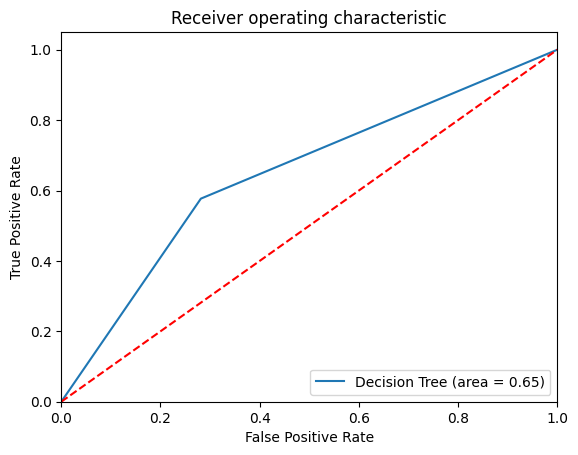

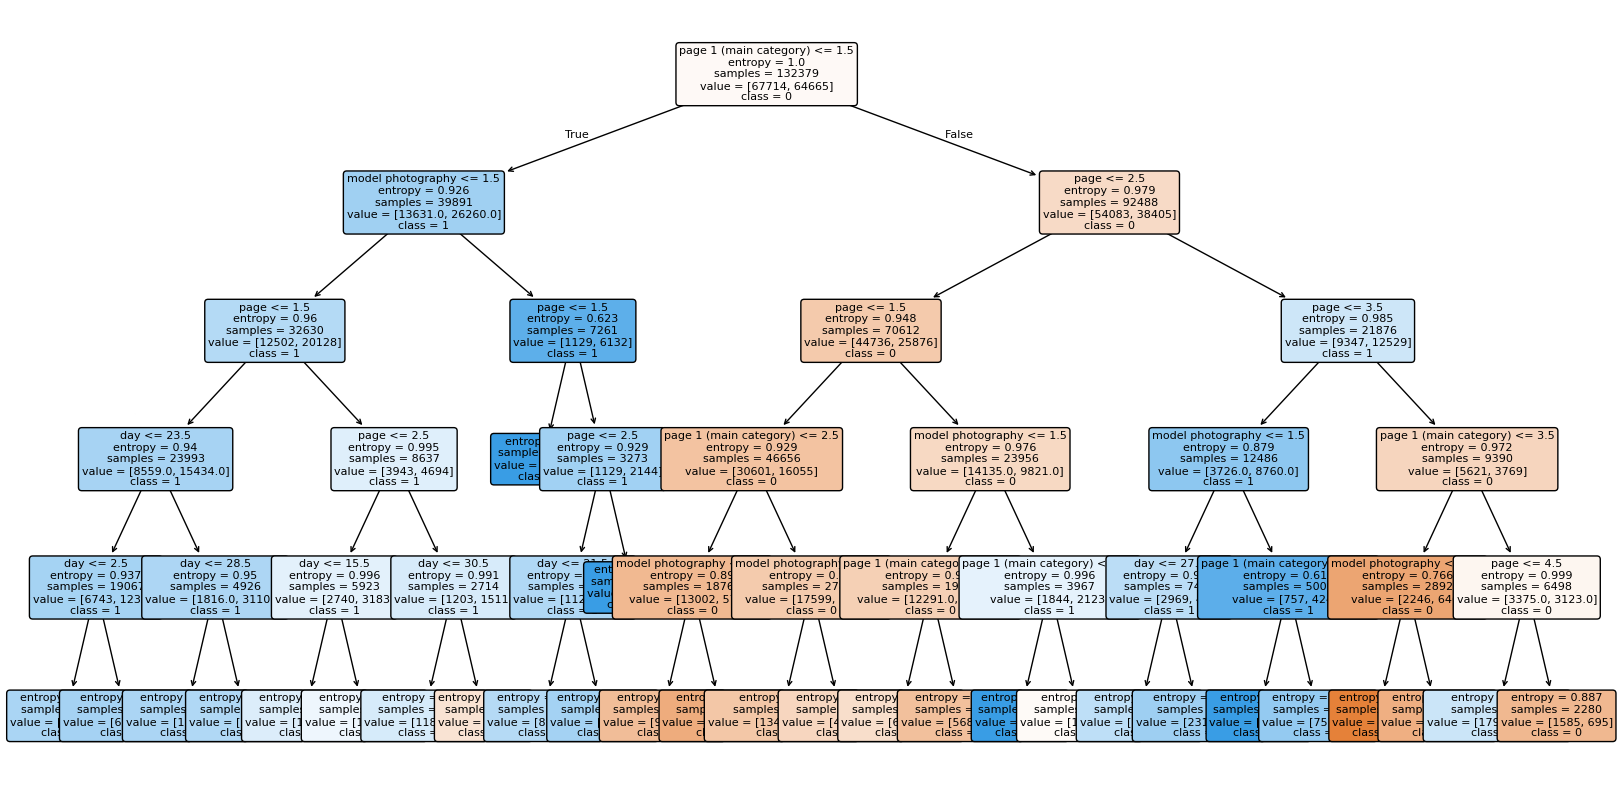

In [44]:
# Evaluacija klasifikacijskog modela

# Točnost modela
accuracy = accuracy_score(y_tree_test, y_tree_pred)
print(f"Točnost modela: {accuracy}")

# Matrica zabune
cm = confusion_matrix(y_tree_test, y_tree_pred)
print(f"Matrica konfuzije:\n{cm}")

# Izvješće o klasifikaciji
print(classification_report(y_tree_test, y_tree_pred))

# ROC krivulja i AUC
fpr, tpr, thresholds = roc_curve(y_tree_test, y_tree_pred)
logit_roc_auc = roc_auc_score(y_tree_test, y_tree_pred)

plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Vizualizacija stabla odlučivanja
plt.figure(figsize=(20, 10))
plot_tree(model_stabla, feature_names=X_tree_train.columns, class_names=['0', '1'], filled=True, rounded=True, fontsize=8)
plt.show()

Sada ćemo probati optimizirati stablo odlučivanja s metodom križne validacije

Najbolja dubina stabla: 6
Najbolja točnost: 0.6652263454236031
Točnost najboljeg modela na testnom skupu: 0.6631213174195498


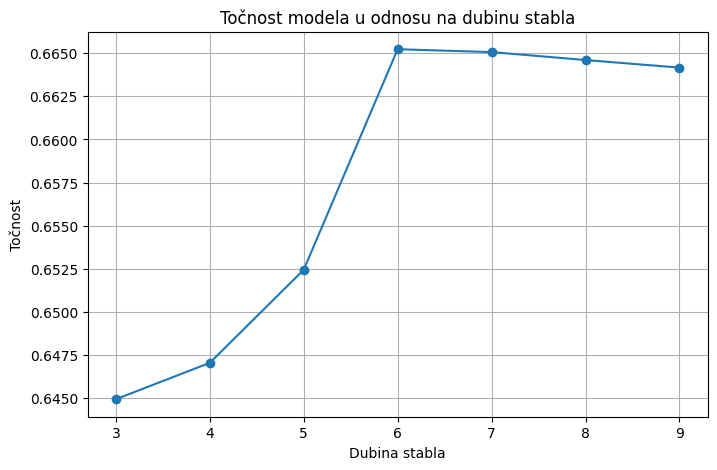

In [45]:
#
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': np.arange(3, 10)}
tree = DecisionTreeClassifier(criterion='entropy',random_state=42)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tree_train, y_tree_train)


best_depth = grid_search.best_params_['max_depth']

print("Najbolja dubina stabla:", best_depth)
print("Najbolja točnost:", grid_search.best_score_)

best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_tree_test)
accuracy_best = accuracy_score(y_tree_test, y_pred_best)
print(f"Točnost najboljeg modela na testnom skupu: {accuracy_best}")

#viz
scores = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(8,5))
plt.plot(param_grid['max_depth'], scores, marker='o')
plt.xlabel('Dubina stabla')
plt.ylabel('Točnost')
plt.title('Točnost modela u odnosu na dubinu stabla')
plt.grid(True)
plt.show()

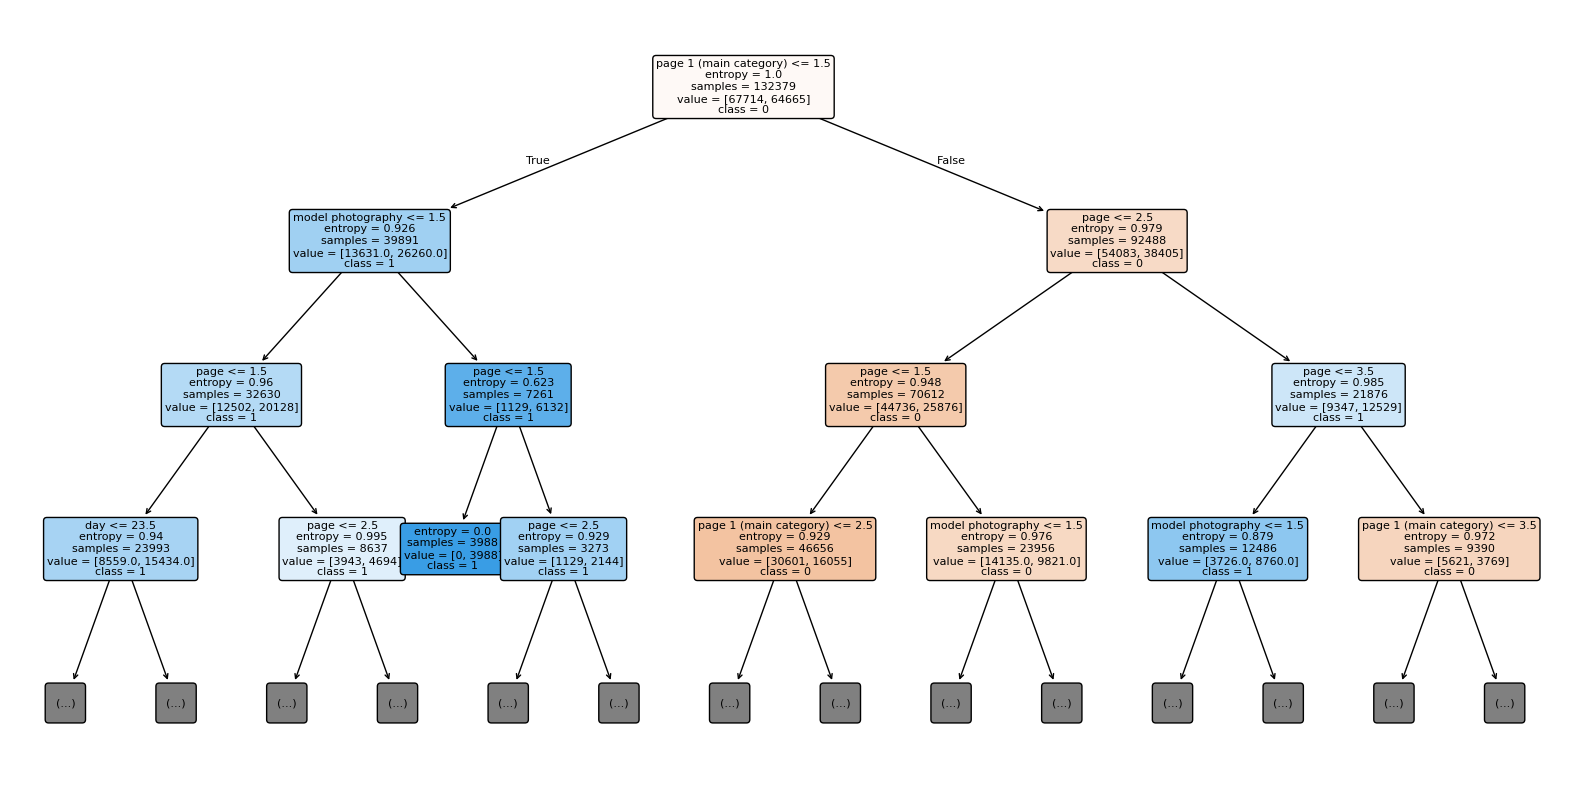

In [47]:
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=X_tree_train.columns, class_names=['0', '1'], filled=True, rounded=True, fontsize=8, max_depth=3) #ograničavam dubinu na 3 da bi vizualizacija bila čitljivija
plt.show()